In [1]:
import os
from pathlib import Path
os.chdir(os.path.join(Path(os.path.abspath('')).parent.resolve()))
print(os.getcwd())

import sys
sys.path.append(os.path.dirname(os.path.realpath(Path(os.path.abspath('')).parent.resolve())))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import shap
from sklearn.model_selection import train_test_split

def get_shap_dict_full_dim(shap_path, imp='zero', rr_list=[5, 30, 60], pred_list=[0, 6, 12], model=None):
    shap_dict = {}
    for rr in rr_list:
        for pred in pred_list:

            if rr == 5:
                data_len = 144
            elif rr == 30:
                data_len = 24
            else:
                data_len = 12
            root_folder = os.path.join(os.path.abspath('.'), f'processed/patient_data/dx_pred_{pred}_12_3src')
            data_folder = os.path.join(os.path.abspath('.'), f'processed/patient_data/dx_pred_{pred}_12_3src/ts_aligned')

            feature_static = pd.read_csv(
                os.path.join(data_folder, 'pos', 'info', os.listdir(os.path.join(data_folder, 'pos', 'info'))[0]),
                sep=';', header=0, index_col=[0]).columns.to_list()
            feature_ts = pd.read_csv(
                os.path.join(data_folder, 'pos', 'data', os.listdir(os.path.join(data_folder, 'pos', 'data'))[0]),
                sep=';', header=0, index_col=[0, 1]).columns.to_list()

            if model in ['RF', 'SVM']:
                shap_values = np.load(os.path.join(shap_path, f'pred{pred}-imp{imp}-sampling{rr}-raw-shap.npy'))
                if len(shap_values.shape) == 3:
                    shap_values = np.concatenate((shap_values[0], shap_values[1]), axis=0)
                
                shap_mean = []
                shap_abs_mean = []

                tmp = shap_values[:, 4:]
                tmp = tmp.reshape(tmp.shape[0], data_len, 33)
                shap_mean.append(tmp.mean(axis=1))
                shap_abs_mean.append(np.mean(np.abs(tmp), axis=1))

                shap_ts = shap_mean[0][:, np.argsort(feature_ts)]
                shap_val = np.concatenate((shap_values[:, :4], shap_ts*data_len), axis=1)
                shap_val = np.abs(shap_val).mean(axis=0)

                # shap_val = np.abs(shap_mean[0]).mean(axis=0)

                shap_dict[(pred, rr)] = shap_val
            else: 
                shap_values = np.load(os.path.join(shap_path, f'pred{pred}-imp{imp}-sampling{rr}.npz'), 
                                      allow_pickle=True)['shap']
                shap_ts = shap_values[1].mean(axis=1)
                shap_val = np.concatenate((shap_values[0][:, 0, :], shap_ts*data_len), axis=1)
                shap_val = np.abs(shap_val).mean(axis=0)
                
                shap_dict[(pred, rr)] = shap_val

            
        
    return shap_dict, feature_static+sorted(feature_ts)


def get_shap_dict_compact(shap_path, imp='zero', pred_list=[0, 6, 12]):
    shap_dict = {}
    
    for pred in pred_list:
        
        feature_names = ['Gender', 'Age', 'AdmissionWeight', 'AdimissionHeight',
           'HR_mean', 'HR_std', 'HR_trend',
           'SpO2_mean', 'SpO2_std', 'SpO2_trend',
           'Respiration_mean', 'Respiration_std', 'Respiration_trend',
           'CVP_mean', 'CVP_std', 'CVP_trend',
           'NIBP_d_mean', 'NIBP_d_std', 'NIBP_d_trend',
           'NIBP_m_mean', 'NIBP_m_std', 'NIBP_m_trend',
           'NIBP_s_mean', 'NIBP_s_std', 'NIBP_s_trend',
           'Urine',
           'GLC', 'K', 'HCO3', 'Na', 'Urea', 'Cr', 'Cl', 'Ca', 'HBG',
           'PLT', 'RBC', 'WBC', 'MCHC', 'MCV', 'MCH', 'RDW', 'Mg', 'MPV',
           'PH', 'PAO2', 'PACO2', 'Baseexcess', 'SAO2', 'Caionized', 'METHB', 'COHB',
        ]

      
        shap_values = np.load(os.path.join(shap_path, f'pred{pred}-imp{imp}-processed-shap.npy'))
        if len(shap_values.shape) == 3:
            shap_values = np.concatenate((shap_values[0], shap_values[1]), axis=0)

        shap_val = np.abs(shap_values).mean(axis=0)

        # shap_val = np.abs(shap_mean[0]).mean(axis=0)

        shap_dict[pred] = shap_val

    return shap_dict, feature_names

/home/dhm/workspace/conference_projects/MICCAI2022_AKF_feature_importance


# Z test

In [2]:
z_score = {}

for pred in [0, 6, 12]:

    root_folder = os.path.join(os.path.abspath('.'), f'processed/patient_data/dx_pred_{pred}_12_3src')
    data_folder = os.path.join(os.path.abspath('.'), f'processed/patient_data/dx_pred_{pred}_12_3src/ts_aligned')

    feature_static = pd.read_csv(
        os.path.join(data_folder, 'pos', 'info', os.listdir(os.path.join(data_folder, 'pos', 'info'))[0]),
        sep=';', header=0, index_col=[0]).columns.to_list()
    feature_ts = pd.read_csv(
        os.path.join(data_folder, 'pos', 'data', os.listdir(os.path.join(data_folder, 'pos', 'data'))[0]),
        sep=';', header=0, index_col=[0, 1]).columns.to_list()

    result = np.load(os.path.join(root_folder, f'ztest-result-{pred}.npz'), allow_pickle=True)['arr_0'].item()

    feat_list = feature_static + sorted(feature_ts)
    
    for key in feat_list:
        if pred not in z_score:
            z_score[pred] = []
        z_score[pred].append(abs(result[key][0]))
        
ztest_importances = pd.DataFrame(z_score, index=feat_list)

fig, ax = plt.subplots(figsize=(16,4))
ztest_importances.plot.bar(ax=ax)


ax.set_ylabel("Z-score", fontsize=14)
ax.legend(labels=['0 h', '6 h', '12 h'], fontsize=12)
ax.tick_params(axis='both', labelsize=12)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right");

# SVM

In [2]:
svm_path = 'models/SVM'
svm_processed_path = os.path.join(svm_path, 'SVM_processed_shap')
svm_raw_path = os.path.join(svm_path, 'SVM_raw_shap')

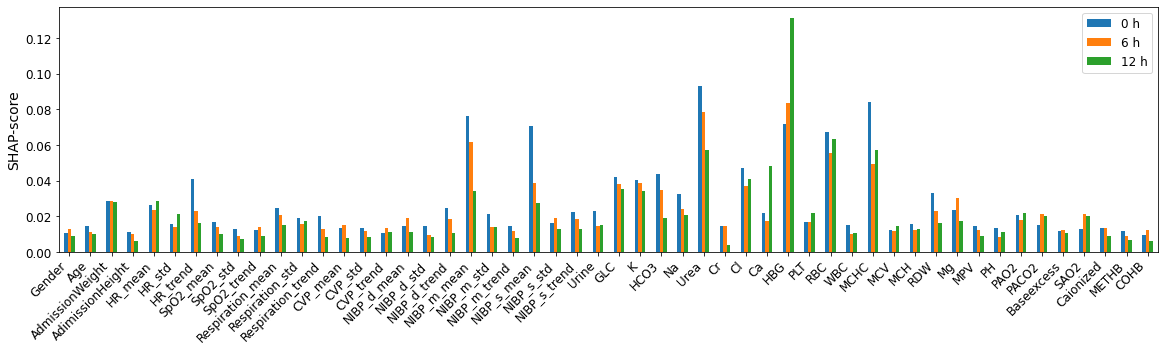

In [4]:
imp = 'zero'
pred_list=[0, 6, 12]

shap_dict, feat_list = get_shap_dict_compact(svm_processed_path, imp=imp, pred_list=pred_list)
svm_importances = pd.DataFrame(shap_dict, index=feat_list)

fig, ax = plt.subplots(figsize=(16,4))
fig.tight_layout()
svm_importances.plot.bar(ax=ax).legend(loc='upper left', fontsize=12)

ax.set_ylabel("SHAP-score", fontsize=14)

ax.legend(labels=['0 h', '6 h', '12 h'], fontsize=12)

ax.tick_params(axis='both', labelsize=12)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right");


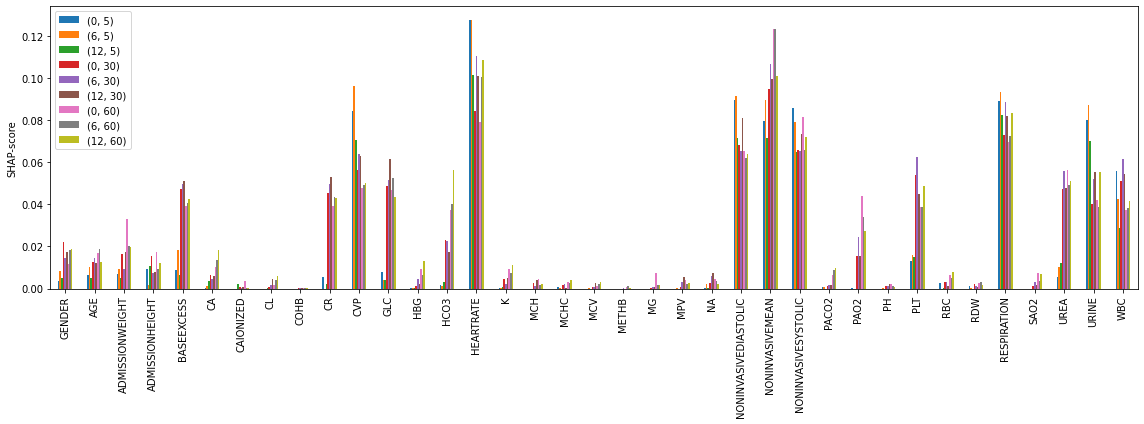

In [6]:
imp = 'zero'
rr_list=[5, 30, 60]
pred_list=[0, 6, 12]

shap_dict, feat_list = get_shap_dict_full_dim(svm_raw_path, imp, rr_list=rr_list, pred_list=pred_list, model='SVM')
svm_importances = pd.DataFrame(shap_dict, index=feat_list)

fig, ax = plt.subplots(figsize=(16,6))
svm_importances.plot.bar(ax=ax).legend(loc='upper left')
# ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("SHAP-score")
fig.tight_layout()

# RF

In [7]:
rf_path = 'models/RF'
rf_processed_path = os.path.join(rf_path, 'RF_processed_shap')
rf_raw_path = os.path.join(rf_path, 'RF_raw_shap')

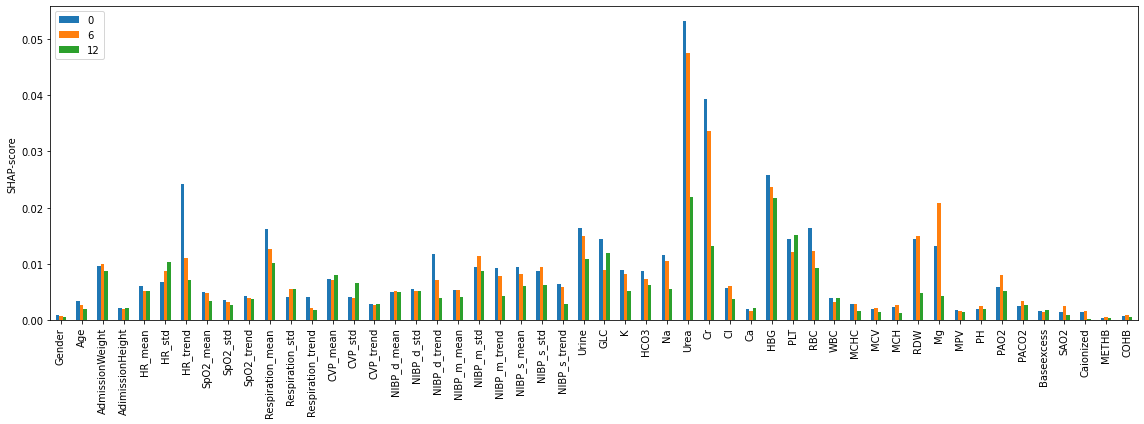

In [8]:
imp = 'zero'
pred_list=[0, 6, 12]

shap_dict, feat_list = get_shap_dict_compact(rf_processed_path, imp=imp, pred_list=pred_list)
rf_importances = pd.DataFrame(shap_dict, index=feat_list)

fig, ax = plt.subplots(figsize=(16,6))
rf_importances.plot.bar(ax=ax).legend(loc='upper left')
# ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("SHAP-score")
fig.tight_layout()

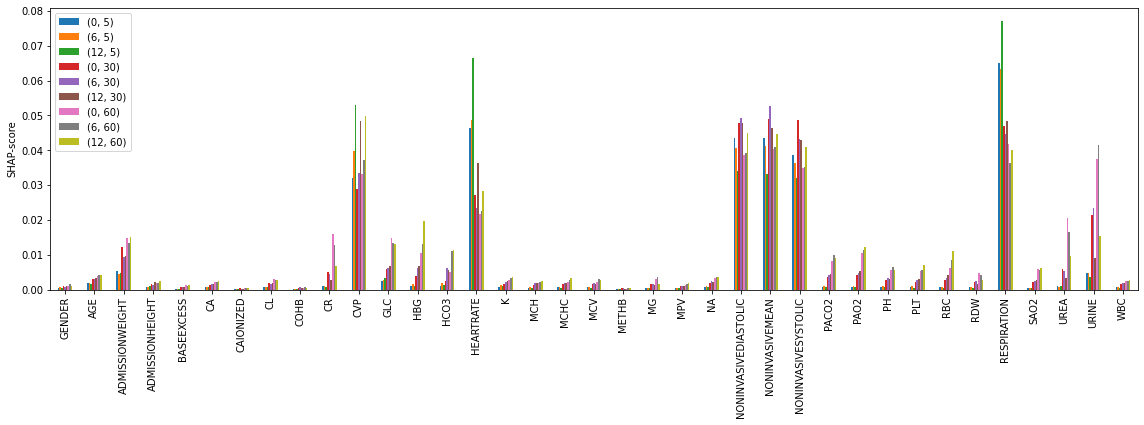

In [10]:
imp = 'zero'
rr_list=[5, 30, 60]
pred_list=[0, 6, 12]

shap_dict, feat_list = get_shap_dict_full_dim(rf_raw_path, imp, rr_list=rr_list, pred_list=pred_list, model='RF')
rf_importances = pd.DataFrame(shap_dict, index=feat_list)

fig, ax = plt.subplots(figsize=(16,6))
rf_importances.plot.bar(ax=ax).legend(loc='upper left')
# ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("SHAP-score")
fig.tight_layout()

# CNN

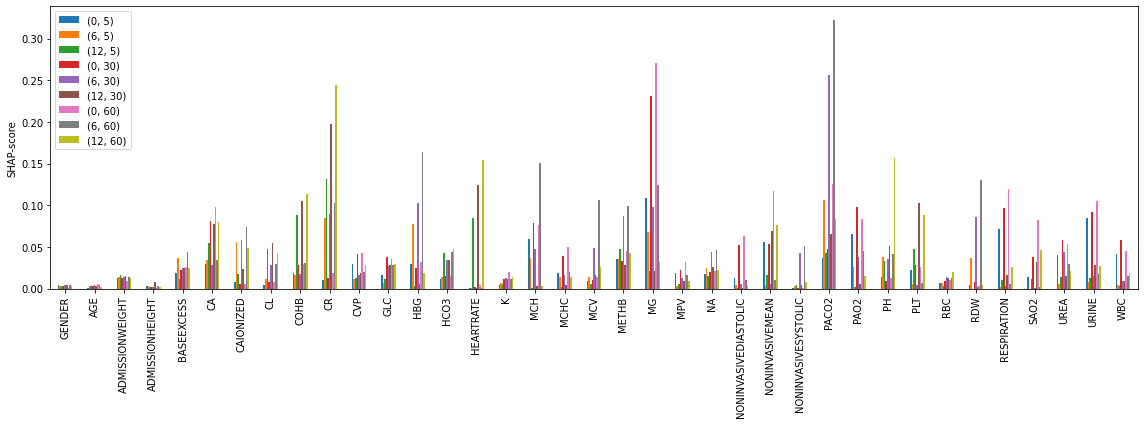

In [11]:
cnn_path = 'models/Conv1D_torch'
cnn_shap_path = os.path.join(cnn_path, 'shap')

imp = 'zero'
rr_list=[5, 30, 60]
pred_list=[0, 6, 12]

shap_dict, feat_list = get_shap_dict_full_dim(cnn_shap_path, imp, rr_list=rr_list, pred_list=pred_list, model='CNN')
cnn_importances = pd.DataFrame(shap_dict, index=feat_list)

fig, ax = plt.subplots(figsize=(16,6))
cnn_importances.plot.bar(ax=ax).legend(loc='upper left')
# ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("SHAP-score")
fig.tight_layout()

# LSTM

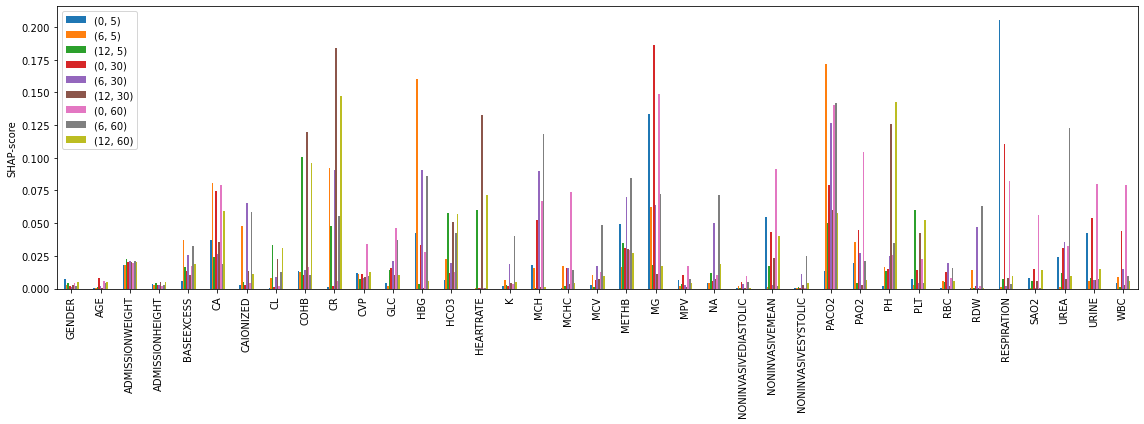

In [12]:
lstm_path = 'models/LSTM_torch'
lstm_shap_path = os.path.join(lstm_path, 'shap')

imp = 'zero'
rr_list=[5, 30, 60]
pred_list=[0, 6, 12]

shap_dict, feat_list = get_shap_dict_full_dim(lstm_shap_path, imp, rr_list=rr_list, pred_list=pred_list, model='CNN')
lstm_importances = pd.DataFrame(shap_dict, index=feat_list)

fig, ax = plt.subplots(figsize=(16,6))
lstm_importances.plot.bar(ax=ax).legend(loc='upper left')
# ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("SHAP-score")
fig.tight_layout()

# LSTM_ATT

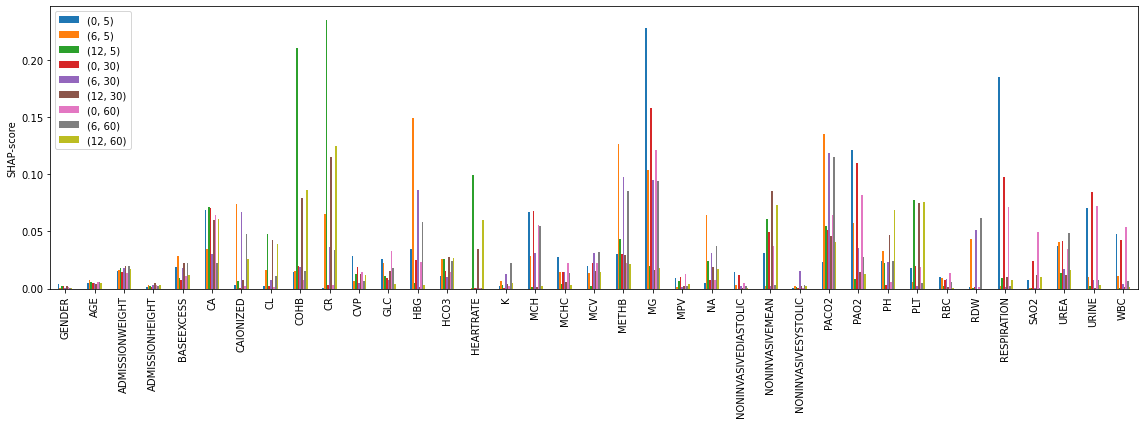

In [28]:
lstmatt_path = 'models/LSTMATT_torch'
lstmatt_shap_path = os.path.join(lstmatt_path, 'shap')

imp = 'zero'
rr_list=[5, 30, 60]
pred_list=[0, 6, 12]

shap_dict, feat_list = get_shap_dict_full_dim(lstmatt_shap_path, imp, rr_list=rr_list, pred_list=pred_list, model='CNN')
lstmatt_importances = pd.DataFrame(shap_dict, index=feat_list)

fig, ax = plt.subplots(figsize=(16,6))
lstmatt_importances.plot.bar(ax=ax).legend(loc='upper left')
# ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("SHAP-score")
fig.tight_layout()

# Model comparison

In [24]:
model_list = ['RF', 'SVM', 'CNN', 'LSTM', 'LSTMATT']
shap_list = [rf_importances, svm_importances, cnn_importances, lstm_importances, lstmatt_importances]

NameError: name 'rf_importances' is not defined

In [23]:
pred = 12
imp = 'zero'
rr = 5

df = pd.DataFrame(index=shap_list[0].index)
for model, shap in zip(model_list, shap_list):
    df[model] = shap[(pred, rr)]
    
fig, ax = plt.subplots(figsize=(16,6))
fig.tight_layout()
df.plot.bar(ax=ax).legend(loc='upper left', fontsize=12)

ax.set_ylabel("SHAP-score", fontsize=14)

ax.tick_params(axis='both', labelsize=12)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right");

NameError: name 'shap_list' is not defined

TypeError: set_xlabel() missing 1 required positional argument: 'xlabel'

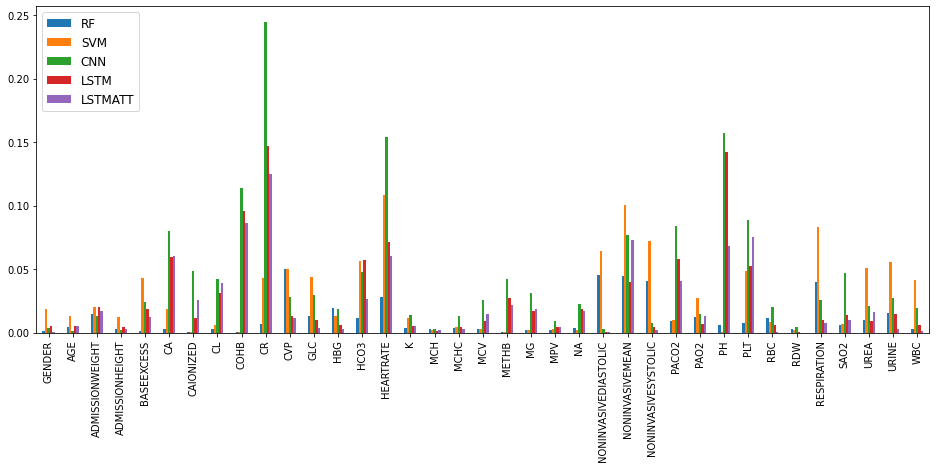

In [31]:
pred = 12
imp = 'zero'
rr = 60

df = pd.DataFrame(index=shap_list[0].index)
for model, shap in zip(model_list, shap_list):
    df[model] = shap[(pred, rr)]
    
fig, ax = plt.subplots(figsize=(16,6))
df.plot.bar(ax=ax).legend(loc='upper left', fontsize=12)
ax.set_xlabel(fontsize=12)
# ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("SHAP-score", fontsize=14)
fig.tight_layout()